# Imports

In [1]:
pip uninstall tensorflow -y && pip install tensorflow==1.15.0 && pip install MulticoreTSNE

Uninstalling tensorflow-2.2.0rc2:
  Successfully uninstalled tensorflow-2.2.0rc2
     |████████████████████████████████| 412.3MB 40kB/s 
     |████████████████████████████████| 3.8MB 32.6MB/s 
     |████████████████████████████████| 512kB 33.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=da1c01c02047965090ef96e9c91c99b9b9b68efe86792dc834d0951793a9e7fd
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")
import dask.dataframe as dd
import seaborn as sns

sns.set(style="darkgrid")

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Dense, Lambda, Dropout, Flatten, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras import backend as K
from keras import regularizers
from keras import losses
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

from keras.optimizers import Adam
import scipy.sparse as sp
from sklearn.metrics.pairwise import cosine_similarity
from MulticoreTSNE import MulticoreTSNE as TSNE

# Functions

In [ ]:
def plot_correlations(data):
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    f, ax = plt.subplots(figsize=(11, 11))  # optional
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=0.3,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
    )

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots()
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.show()

In [ ]:
def filter_matrix(data, min_sessions=5, min_tracks=0):
    def get_counts(data, id):
        _groupbyid = data[[id]].groupby(id, as_index=False)
        return _groupbyid.size()

    if min_tracks > 0:
        trackcount = get_counts(data, "track_id_clean")
        data = data[
            data["track_id_clean"].isin(trackcount.index[trackcount >= min_tracks])
        ]

    if min_sessions > 0:
        sessioncount = get_counts(data, "session_id")
        data = data[
            data["session_id"].isin(sessioncount.index[sessioncount >= min_sessions])
        ]

    sessioncount, trackcount = get_counts(data, "session_id"), get_counts(
        data, "track_id_clean"
    )
    return data, sessioncount, trackcount

In [ ]:
def pad_along_axis(array: np.ndarray, target_length, axis=0):
    pad_size = target_length - array.shape[axis]
    axis_nb = len(array.shape)
    if pad_size < 0:
        return array

    npad = [(0, 0) for x in range(axis_nb)]
    npad[axis] = (0, pad_size)
    return np.pad(array, pad_width=npad, mode="constant", constant_values=0)

In [ ]:
def _mean_ranking_metric(predictions, labels, metric):
    return np.mean(
        [
            metric(np.asarray(prd), np.asarray(labels[i]))
            for i, prd in enumerate(predictions)
        ]
    )


def _warn_for_empty_labels():
    warnings.warn("empty ground truth set!")
    return 0.0


def mean_average_precision(predictions, labels, assume_unique=True):
    def _inner_map(pred, lab):
        if lab.shape[0]:
            n = pred.shape[0]
            arange = np.arange(n, dtype=np.float32) + 1.0
            present = np.in1d(pred[:n], lab, assume_unique=assume_unique)
            prec_sum = np.ones(present.sum()).cumsum()
            denom = arange[present]
            return (prec_sum / denom).sum() / lab.shape[0]

        else:
            return _warn_for_empty_labels()

    return _mean_ranking_metric(predictions, labels, _inner_map)


def coverage(predicted, catalog):

    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_predictions = len(set(predicted_flattened))
    coverage = round(unique_predictions / (len(catalog) * 1.0), 4)
    return coverage


def personalization(predicted):
    def make_rec_matrix(predicted, unique_recs):
        rec_matrix = pd.DataFrame(index=range(len(predicted)), columns=unique_recs)
        rec_matrix.fillna(0, inplace=True)
        for i in rec_matrix.index:
            rec_matrix.loc[i, predicted[i]] = 1
        return rec_matrix

    # get all unique items recommended
    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_recs = list(set(predicted_flattened))

    # create matrix for recommendations
    rec_matrix = make_rec_matrix(predicted, unique_recs)
    rec_matrix_sparse = sp.csr_matrix(rec_matrix.values)

    # calculate similarity for every user's recommendation list
    similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)

    # get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    # calculate average similarity
    personalization = np.mean(similarity[upper_right])
    return 1 - personalization

In [ ]:
def recommender_for_session(id, interaction_matrix, top=10):
    pred_scores = interaction_matrix.loc[id].values
    df_scores = pd.DataFrame(
        {"track_id": list(interaction_matrix.columns), "score": pred_scores}
    )

    df_rec = (
        df_scores.set_index("track_id")
        .sort_values("score", ascending=False)
        .head(top)[["score"]]
    )
    return df_rec[df_rec.score > 0]

# Data

## Preprocessing: Logs

### Preprocessing: Local
to sample data

In [14]:
LOCAL_DIR = "/media/starscream/wheeljack/learn/university_of_toronto/project/"

In [6]:
log = dd.read_csv("{}data/logs/*.csv".format(LOCAL_DIR))
log = log.compute()

In [7]:
items = 1000000
cols = ["session_id", "session_position", "track_id_clean"]
log.sort_values(by=cols, inplace=True)
log = log[log.not_skipped == True]
log = log[cols].head(items)

In [8]:
cols = ["session_id", "track_id_clean"]
log = (
    log.groupby(cols)
    .count()
    .reset_index()
    .rename(columns={"session_position": "counts"})
)
log.sort_values(by="counts", ascending=False, inplace=True)
log.head()

,session_id,track_id_clean,counts
46744,0_0d0c420b-8759-452a-8f4f-d1dc59af3576,t_b362a386-e30e-46be-bb44-af6efd02260f,19
38033,0_0aa67cfe-7f5b-4373-ac1a-f5ebbf000fce,t_a60cb92b-16be-43ad-91f1-c585c107ec21,19
29647,0_082fdaac-352c-4f2a-b136-5368ac95d6fb,t_b6adf2ac-b8f1-4e0a-a98c-e35c5b7ccb9e,19
16530,0_0489c355-b4a5-4541-88d7-b3584ba5156c,t_9f5fdc6a-3aed-45b7-a8d8-750160b87098,18
50802,0_0e24f007-3f5f-44cf-8b05-6addcc8311cb,t_f6a265e7-e8ff-4d10-bd0c-4ab5b2ae9abd,17


In [10]:
log.to_parquet(
    "{}data/log_trunc.parquet.gzip".format(LOCAL_DIR), compression="gzip", index=False
)

### Preprocessing: Truncated Data

In [8]:
log = dd.read_parquet("log_trunc.parquet.gzip", compression="gzip").compute()
log.head()

,session_id,track_id_clean,counts
0,0_21b7be21-2024-4efe-a6e8-752eae5da214,t_22e40bd8-c321-43c4-9108-9693926a5c7d,19
1,0_3dd97cfa-fd65-4f49-964d-9865a03399f7,t_a8379e5d-6fb4-4d5d-91af-54514c50d54c,19
2,0_be84e9be-2761-4be7-9696-f81edc6e4631,t_bacf06d3-9185-4183-84ea-ff0db51475ce,19
3,0_43f9196c-ff7a-42dc-a140-65ab05800def,t_e1528f92-03f3-4397-b349-6a79ba7ad7d1,19
4,0_a6a1fb24-28fa-46b2-bafd-509a5e20046a,t_3bbfb876-bceb-4649-813b-ebacbb368d51,19


In [9]:
filtered_data, counts_sessions, counts_tracks = filter_matrix(
    log, min_sessions=10, min_tracks=5
)
sparsity = 1 - 1.0 * filtered_data.shape[0] / (
    counts_sessions.shape[0] * counts_tracks.shape[0]
)

print(
    "After filtering, there are %d plays from %d sessions and %d tracks (sparsity: %.3f%%)"
    % (
        filtered_data.shape[0],
        counts_sessions.shape[0],
        counts_tracks.shape[0],
        sparsity * 100,
    )
)

After filtering, there are 235162 plays from 18610 sessions and 19845 tracks (sparsity: 99.936%)


In [10]:
log = log.merge(
    filtered_data[["session_id"]].drop_duplicates(), how="inner", on="session_id"
)
print(log.shape)

(246268, 3)


### Interaction Matrix

In [11]:
interaction_matrix_df = filtered_data.pivot(
    index="session_id", columns="track_id_clean", values="counts"
).fillna(0)
interaction_matrix_df.head()

track_id_clean,t_0000dc06-0c00-4a09-9dc6-3bdad9c6f0e8,t_00042d9b-e795-41a9-89ad-504373dd4287,t_0004aa5d-1e27-4446-995a-43ae94d2b490,t_000518e0-996c-46b0-9167-f831f5f8f513,t_0007a9bf-2faf-4345-b005-388b1d9e3d94,t_00094c95-4dc3-4d6f-afee-b91fda2294d1,t_000b6ec2-e98f-4f8e-a955-606e092b25f0,t_000c67b0-6ef3-48d6-97c9-29526f9d2d8d,t_000d49ad-9288-48c1-a429-efe379df99f7,t_00105455-8be7-4214-a8d5-ec8f6b52a79b,t_00138857-0bdb-47f1-a88f-5546118a575b,t_00174427-afef-4a1c-be96-38c2b6f01396,t_001fda0c-b887-4756-85de-9cf07eeb9f01,t_00210615-f083-4ef4-9c23-0922f3550d66,t_0022d7b7-65ce-4493-9f83-fb42314b7038,t_00296132-945b-4578-8722-0961db0c5063,t_002d7696-93f8-45a8-bb21-2a808933b408,t_003a1b5b-8de4-4b67-a7b9-63b4449d172f,t_003f8a4f-f4d1-42b9-b287-1462adcc36ec,t_004020a3-8f5d-47f5-9c06-b03cb0fd1c74,t_004bb228-a1ab-432a-b425-ada40f0e44bc,t_004c724a-2131-4f1c-9b0c-c824a196dbcb,t_005261c2-b5bd-4991-8a38-c0dbb05d0922,t_005987b9-82f0-4098-878e-905dd7ec4385,t_006061c2-f535-4117-9b66-be95948745b2,t_006081a8-0977-4833-8117-f2cfde6d60fd,t_00642388-12bc-4104-a63c-7db835fe0af4,t_0066326c-d776-4eae-a355-93ea0a05caab,t_006e18dd-7564-4850-8a29-86369ed86c8a,t_006feee8-27eb-4ff0-a2e0-f3d0a7815b31,t_007346de-1bbb-411b-8dd0-560ae72fdeb3,t_00750953-913d-4950-94a2-285b662c32f3,t_00796d06-2f3e-47ba-abb4-728da542de09,t_007eec3b-fa45-45a6-b913-9ae0a93dd7ba,t_0082520d-ab5f-48a1-b361-b30af55edf8d,t_008279d5-19ef-419e-b651-04031981bd99,t_0090dbf9-cd48-44d4-9207-413d9954c41a,t_00916c7c-e911-4445-b79a-0284830ea536,t_00919315-abf5-4869-9d25-213d27c51f73,t_0091e8b1-374a-4f3e-b0bd-f90687ad1f9a,...,t_ff9c77f6-8c8b-4a34-b118-95e81627e3c5,t_ff9cc39a-11b8-454d-a43a-1583f38b3494,t_ff9ce9d6-b330-44ec-8c97-6a78ce67adaf,t_ffa27fa4-7256-41ee-b317-a47868b96cec,t_ffa3b224-a4f5-420f-861e-d12b480f8a6b,t_ffa3f61c-0df6-4a3e-b462-0c88fad2c8ae,t_ffa51171-80a5-40fa-aa0a-b1aac6fec744,t_ffa60334-8bea-45b1-bde5-b91e5850ac4d,t_ffacec29-dced-4266-9112-4d14b6fbab8d,t_ffb11621-8bcb-4eed-94ad-b9fb2a0b2fd9,t_ffb1642a-0b78-4193-88a9-aa2b8525927b,t_ffb50689-9393-47c7-bf34-2a864e8eb478,t_ffb76fb9-3f42-4f0a-a09e-956df38e5c47,t_ffb7a66d-8398-4701-9119-0961b1af0b38,t_ffb7ca71-83d3-46f3-a579-d2630476ab74,t_ffbd2b1e-fe2d-4099-b5b8-de6cf97a6b20,t_ffbdb717-e7b9-46f5-bb2a-9c9ef0878f3a,t_ffc1338c-95d0-4669-88d8-4d90a6d08459,t_ffc37789-d3ce-4aa6-8e89-067ab0f18b21,t_ffc898b9-13f8-4338-8252-156b7b8dca71,t_ffc8991a-ba02-46ec-aa84-bf92269b5a45,t_ffc9a28f-1014-46e1-8d37-f8c3744752f3,t_ffc9f6c7-32da-4520-a661-2ddd714b74c1,t_ffcacf38-1cdb-4ce3-bd5e-648868c93180,t_ffce0dcf-87e9-4826-9499-f535b9b1caab,t_ffd4cf60-85ee-479b-afee-558a62da0555,t_ffd59094-8ee6-41bf-bc39-ca5e1148c6eb,t_ffd70455-5083-4171-92c4-e8b185e7666c,t_ffdf73bf-7b3b-476a-9031-e262fa3339e6,t_ffe124f6-1b3f-4b75-aa8d-10d6736309df,t_ffe4f45a-c85b-487e-b909-c9a401ab9130,t_ffe927bb-0453-409f-a420-65f2e9e493e7,t_ffecf968-2ea1-4fda-98e0-ebd43e313425,t_ffed690f-6007-4724-ae05-d4e948dd8f34,t_fff16c88-5073-4707-9204-bb56a43d1538,t_fff4a19e-bb6c-4e1e-baba-bbf846115ae7,t_fff5d444-7ab5-4332-a1c8-3c2416686299,t_fff9b035-3943-4557-bdd0-15fc2c5dc03e,t_fffb0ec7-cbd3-4075-bdad-7e57bada2a02,t_fffe4528-f29c-467c-a751-e9db03964faa
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0_0001df8e-1221-4079-adf3-b8ccfd23b8b6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_000371cd-7db2-44fb-be34-f4832eb07ee8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_00048b8c-ea97-477b-a011-65e164a560de,0.0,

In [19]:
interaction_matrix_df.values.mean() * 100

0.06500919471416644

## Preprocessing: Content

### Preprocessing: Local
to sample data

In [15]:
content = dd.read_csv("{}data/tf_large.csv".format(LOCAL_DIR))
content = content.compute()
print(content.track_id.nunique())

1853311


In [ ]:
content.drop(columns=["mode"], inplace=True)
content = log[["track_id_clean"]].merge(
    content, how="inner", left_on="track_id_clean", right_on="track_id"
)
content.to_parquet(
    "{}data/content_trunc.parquet.gzip".format(LOCAL_DIR),
    compression="gzip",
    index=False,
)

### Preprocessing: Truncated Data

In [29]:
content = dd.read_parquet("content_trunc.parquet.gzip", compression="gzip").compute()
cols = content.columns.values[2:]
content[cols] = content[cols].astype(float).round(2)
content.head()

,track_id_clean,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a8379e5d-6fb4-4d5d-91af-54514c50d54c,t_a8379e5d-6fb4-4d5d-91af-54514c50d54c,231.33,2018.0,100.00,0.59,0.63,0.63,0.79,8.96,0.45,1.05,0.00,10.0,0.11,-4.77,0.79,0.44,0.05,120.06,4.0,0.59,-0.87,0.33,0.26,0.07,-0.28,0.01,-0.51,0.21
1,t_bacf06d3-9185-4183-84ea-ff0db51475ce,t_bacf06d3-9185-4183-84ea-ff0db51475ce,217.93,2018.0,100.00,0.06,0.85,0.86,0.83,12.55,0.63,1.04,0.00,1.0,0.40,-5.83,0.85,0.11,0.13,91.03,4.0,0.35,-0.78,0.33,0.26,0.03,-0.34,0.02,-0.44,0.14
2,t_3bbfb876-bceb-4649-813b-ebacbb368d51,t_3bbfb876-bceb-4649-813b-ebacbb368d51,211.30,2017.0,97.20,0.98,0.21,0.15,0.18,3.63,0.07,1.06,0.96,7.0,0.10,-25.93,0.12,0.93,0.04,71.61,4.0,0.04,0.56,-0.52,-0.27,0.13,-0.39,-0.05,0.06,0.20
3,t_5b7ab61b-ada4-48b8-9cb5-27ebc11ee8d6,t_5b7ab61b-ada4-48b8-9cb5-27ebc11ee8d6,304.41,2010.0,99.89,0.57,0.38,0.46,0.62,7.91,0.38,1.04,0.02,5.0,0.11,-9.32,0.61,0.49,0.03,147.70,3.0,0.22,0.03,-0.11,0.24,-0.15,0.01,0.15,-0.35,-0.23
4,t_90fb83b4-81bd-449b-8b29-6173028ecd58,t_90fb83b4-81bd-449b-8b29-6173028ecd58,137.17,2017.0,100.00,0.15,0.70,0.78,0.92,12.32,0.69,0.98,0.00,9.0,0.10,-7.54,0.81,0.17,0.09,118.98,4.0,0.71,-0.16,0.14,0.10,-0.25,-0.12,0.21,-0.11,0.18


In [30]:
print(log.track_id_clean.nunique())
print(content.track_id.nunique())
print(content.shape)

29773
85985
(85985, 30)


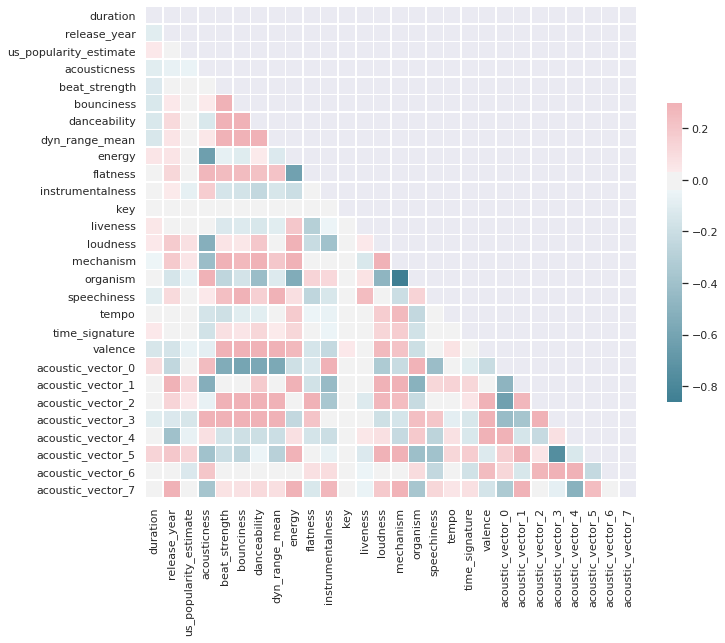

In [31]:
plot_correlations(content)

In [32]:
content.drop(
    columns=["track_id", "key", "duration", "us_popularity_estimate"], inplace=True
)
content.shape

(85985, 26)

In [ ]:
cols_num = list(content.select_dtypes(include=[np.number]).columns.values)

scaler = MinMaxScaler()
content[cols_num] = scaler.fit_transform(content[cols_num])

In [34]:
content = log[["session_id", "track_id_clean"]].merge(
    content, how="left", on="track_id_clean"
)
content.drop(columns=["track_id_clean"], inplace=True)
content.head()

,session_id,release_year,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_69507a1f-e65c-4a69-b10e-c783787e1812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0_69507a1f-e65c-4a69-b10e-c783787e1812,0.955882,0.58,0.54,0.646465,0.747475,0.241133,0.76,0.891892,0.00,0.10,0.879766,0.44,0.587629,0.216495,0.387357,0.8,0.494949,0.184466,0.705584,0.713287,0.500000,0.355670,0.695652,0.222857,0.540670
2,0_69507a1f-e65c-4a69-b10e-c783787e1812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0_69507a1f-e65c-4a69-b10e-c783787e1812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0_69507a1f-e65c-4a69-b10e-c783787e1812,0.955882,0.03,0.61,0.595960,0.727273,0.196144,0.91,0.900901,0.01,0.59,0.878658,0.83,0.123711,0.041237,0.436031,0.8,0.404040,0.121359,0.736041,0.769231,0.489691,0.407216,0.753623,0.177143,0.569378


### Session Type Characterization

In [35]:
session_types = content.copy()
print(session_types.session_id.nunique())
cols = session_types.columns.values[1:]
session_types = (
    session_types.groupby("session_id")[cols]
    .mean()
    .reset_index()
    .sort_values(by="danceability", ascending=False)
)

18610


### Content Array Generation

In [36]:
content.set_index("session_id", inplace=True)
content.fillna(0.0, inplace=True)
sessions = list(content.index.get_level_values("session_id").unique())
content_features = np.shape(content.columns.values)[0]
max_events = 5
content_data = []
for session_id in sessions:
    session_data = content[content.index == session_id].values.flatten()[
        : max_events * content_features
    ]
    # session_features = pad_sequences(session_features, maxlen=max_events*content_features, padding='post')
    session_data = pad_along_axis(session_data, max_events, axis=0)
    content_data.append(session_data)
content_data = np.array(content_data)
print(content_data[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.95588235 0.58       0.54       0.64646465 0.74747475
 0.24113306 0.76       0.89189189 0.         0.1        0.87976586
 0.44       0.58762887 0.21649485 0.38735693 0.8        0.49494949
 0.18446602 0.70558376 0.71328671 0.5        0.3556701  0.69565217
 0.22285714 0.54066986 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0

In [37]:
print(len(content_data))
print(interaction_matrix_df.shape)

18610
(18610, 19845)


# Model: Collaborative Filter

## Training

In [ ]:
# input
X = interaction_matrix_df.values
y = interaction_matrix_df.values

In [ ]:
def autoEncoderCollaborative(X):
    """
    Autoencoder for Collaborative Filter
    """

    init = keras.initializers.glorot_uniform()

    # Input
    input_layer = Input(shape=(X.shape[1],), name="input_tracks")

    # Encoder
    enc = Dense(512, activation="selu", name="layer_encoder")(input_layer)
    enc = Dropout(0.1, name="layer_encoder_1d")(enc)

    # Latent Space
    lat_space = Dense(256, activation="selu", name="layer_latent")(enc)
    lat_space = Dropout(0.4, name="Dropout")(lat_space)

    # Decoder
    dec = Dense(512, activation="selu", name="layer_decoder")(lat_space)
    dec = Dropout(0.1, name="layer_decoder_1d")(dec)

    # Output
    output_layer = Dense(X.shape[1], activation="linear", name="output_tracks")(dec)

    model = Model(input_layer, output_layer)
    return model

In [76]:
# Build model
model_c = autoEncoderCollaborative(X)
model_c.compile(optimizer=Adam(lr=0.001), loss="mse")
model_c.summary()

hist_c = model_c.fit(
    x=X, y=y, epochs=25, batch_size=64, shuffle=True, validation_split=0.1
)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_tracks (InputLayer)    (None, 19845)             0         
_________________________________________________________________
layer_encoder (Dense)        (None, 512)               10161152  
_________________________________________________________________
layer_encoder_1d (Dropout)   (None, 512)               0         
_________________________________________________________________
layer_latent (Dense)         (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
layer_decoder (Dense)        (None, 512)               131584    
_________________________________________________________________
layer_decoder_1d (Dropout)   (None, 512)               0  

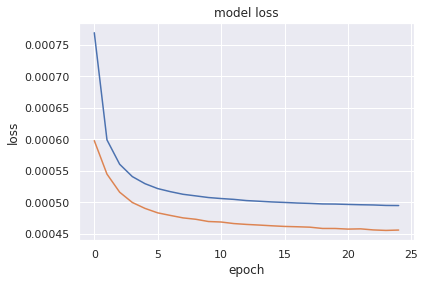

In [77]:
plot_hist(hist_c)

## Prediction

In [ ]:
new_matrix = model_c.predict(X[0]) * (X[0] == 0)

In [101]:
new_interaction_matrix_df = pd.DataFrame(
    new_matrix, columns=interaction_matrix_df.columns, index=interaction_matrix_df.index
)
new_interaction_matrix_df.head()

track_id_clean,t_0000dc06-0c00-4a09-9dc6-3bdad9c6f0e8,t_00042d9b-e795-41a9-89ad-504373dd4287,t_0004aa5d-1e27-4446-995a-43ae94d2b490,t_000518e0-996c-46b0-9167-f831f5f8f513,t_0007a9bf-2faf-4345-b005-388b1d9e3d94,t_00094c95-4dc3-4d6f-afee-b91fda2294d1,t_000b6ec2-e98f-4f8e-a955-606e092b25f0,t_000c67b0-6ef3-48d6-97c9-29526f9d2d8d,t_000d49ad-9288-48c1-a429-efe379df99f7,t_00105455-8be7-4214-a8d5-ec8f6b52a79b,t_00138857-0bdb-47f1-a88f-5546118a575b,t_00174427-afef-4a1c-be96-38c2b6f01396,t_001fda0c-b887-4756-85de-9cf07eeb9f01,t_00210615-f083-4ef4-9c23-0922f3550d66,t_0022d7b7-65ce-4493-9f83-fb42314b7038,t_00296132-945b-4578-8722-0961db0c5063,t_002d7696-93f8-45a8-bb21-2a808933b408,t_003a1b5b-8de4-4b67-a7b9-63b4449d172f,t_003f8a4f-f4d1-42b9-b287-1462adcc36ec,t_004020a3-8f5d-47f5-9c06-b03cb0fd1c74,t_004bb228-a1ab-432a-b425-ada40f0e44bc,t_004c724a-2131-4f1c-9b0c-c824a196dbcb,t_005261c2-b5bd-4991-8a38-c0dbb05d0922,t_005987b9-82f0-4098-878e-905dd7ec4385,t_006061c2-f535-4117-9b66-be95948745b2,t_006081a8-0977-4833-8117-f2cfde6d60fd,t_00642388-12bc-4104-a63c-7db835fe0af4,t_0066326c-d776-4eae-a355-93ea0a05caab,t_006e18dd-7564-4850-8a29-86369ed86c8a,t_006feee8-27eb-4ff0-a2e0-f3d0a7815b31,t_007346de-1bbb-411b-8dd0-560ae72fdeb3,t_00750953-913d-4950-94a2-285b662c32f3,t_00796d06-2f3e-47ba-abb4-728da542de09,t_007eec3b-fa45-45a6-b913-9ae0a93dd7ba,t_0082520d-ab5f-48a1-b361-b30af55edf8d,t_008279d5-19ef-419e-b651-04031981bd99,t_0090dbf9-cd48-44d4-9207-413d9954c41a,t_00916c7c-e911-4445-b79a-0284830ea536,t_00919315-abf5-4869-9d25-213d27c51f73,t_0091e8b1-374a-4f3e-b0bd-f90687ad1f9a,...,t_ff9c77f6-8c8b-4a34-b118-95e81627e3c5,t_ff9cc39a-11b8-454d-a43a-1583f38b3494,t_ff9ce9d6-b330-44ec-8c97-6a78ce67adaf,t_ffa27fa4-7256-41ee-b317-a47868b96cec,t_ffa3b224-a4f5-420f-861e-d12b480f8a6b,t_ffa3f61c-0df6-4a3e-b462-0c88fad2c8ae,t_ffa51171-80a5-40fa-aa0a-b1aac6fec744,t_ffa60334-8bea-45b1-bde5-b91e5850ac4d,t_ffacec29-dced-4266-9112-4d14b6fbab8d,t_ffb11621-8bcb-4eed-94ad-b9fb2a0b2fd9,t_ffb1642a-0b78-4193-88a9-aa2b8525927b,t_ffb50689-9393-47c7-bf34-2a864e8eb478,t_ffb76fb9-3f42-4f0a-a09e-956df38e5c47,t_ffb7a66d-8398-4701-9119-0961b1af0b38,t_ffb7ca71-83d3-46f3-a579-d2630476ab74,t_ffbd2b1e-fe2d-4099-b5b8-de6cf97a6b20,t_ffbdb717-e7b9-46f5-bb2a-9c9ef0878f3a,t_ffc1338c-95d0-4669-88d8-4d90a6d08459,t_ffc37789-d3ce-4aa6-8e89-067ab0f18b21,t_ffc898b9-13f8-4338-8252-156b7b8dca71,t_ffc8991a-ba02-46ec-aa84-bf92269b5a45,t_ffc9a28f-1014-46e1-8d37-f8c3744752f3,t_ffc9f6c7-32da-4520-a661-2ddd714b74c1,t_ffcacf38-1cdb-4ce3-bd5e-648868c93180,t_ffce0dcf-87e9-4826-9499-f535b9b1caab,t_ffd4cf60-85ee-479b-afee-558a62da0555,t_ffd59094-8ee6-41bf-bc39-ca5e1148c6eb,t_ffd70455-5083-4171-92c4-e8b185e7666c,t_ffdf73bf-7b3b-476a-9031-e262fa3339e6,t_ffe124f6-1b3f-4b75-aa8d-10d6736309df,t_ffe4f45a-c85b-487e-b909-c9a401ab9130,t_ffe927bb-0453-409f-a420-65f2e9e493e7,t_ffecf968-2ea1-4fda-98e0-ebd43e313425,t_ffed690f-6007-4724-ae05-d4e948dd8f34,t_fff16c88-5073-4707-9204-bb56a43d1538,t_fff4a19e-bb6c-4e1e-baba-bbf846115ae7,t_fff5d444-7ab5-4332-a1c8-3c2416686299,t_fff9b035-3943-4557-bdd0-15fc2c5dc03e,t_fffb0ec7-cbd3-4075-bdad-7e57bada2a02,t_fffe4528-f29c-467c-a751-e9db03964faa
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0_0001df8e-1221-4079-adf3-b8ccfd23b8b6,0.001347,0.000227,-0.000900,0.000238,0.000134,9.999619e-05,0.000077,0.000990,0.000833,0.000177,0.000591,0.001944,0.000307,0.000308,0.000178,0.000062,-0.000115,0.001623,0.000316,0.000064,-0.000106,0.000875,0.000125,0.004587,0.002898,0.000105,0.000008,0.000415,-0.003912,0.000054,-0.000075,0.013069,0.000128,0.001133,0.001751,0.005503,0.000325,0.000083,-0.000912,0.000656,...,0.000356,0.000129,0.000160,-0.000065,0.000573,0.000352,-0.000201,0.000053,0.000524,0.000357,0.000171,-0.000632,-0.000177,0.000298,-0.001215,0.000482,0.000069,0.000232,-1.297738e-05,0.000299,0.000103,0.000182,-0.000138,0.000047,-0.000147,0.001341,0.000110,0.000221,-0.000561,0.000087,0.002869,-0.000031,0.002097,0.000342,0.000064,0.000146,-0.000013,0.000195

In [102]:
print(new_interaction_matrix_df.values.min(), new_interaction_matrix_df.values.max())

-0.3330533 1.1892387


In [103]:
session_id = "0_00168010-e7c4-4ef2-a2c1-b1cd227300ef"
recommender_for_session(id=session_id, interaction_matrix=interaction_matrix_df, top=10)

,score
track_id,
t_bc898253-bfa0-40e4-b911-6673ae75a8df,1.0
t_300b9c3c-8577-40cf-8528-1c8e9374112b,1.0
t_1051bc37-1a73-4301-812b-f83ae0c9bbcd,1.0
t_b3db6567-f986-4b8f-bd7a-04057448ab3a,1.0
t_e48d2f95-ecab-498a-a418-f76f022097e0,1.0
t_87e4ce4c-6b35-4aed-9c6b-bbe3acc02a8a,1.0
t_5e235989-6bf5-4a0a-842f-8289876b0ce1,1.0
t_29660694-2f35-4a10-b5cd-74d077f590a5,1.0
t_4712dda0-751b-452e-a594-bb5835a5bb7a,1.0


In [104]:
recommender_for_session(id=session_id, interaction_matrix=new_interaction_matrix_df)

,score
track_id,
t_6fc7f3ed-639d-4990-8bcd-86f42034b605,0.536178
t_6fa45ab2-f050-439e-a758-c92f8514e7fa,0.135819
t_4ffd14f1-5406-4cfa-a9ed-a91a0f49b5bd,0.103118
t_7b283293-aaf2-4da3-b1f8-ef728a67a397,0.098149
t_1529b294-ec4b-4c46-a302-37f39a23d24e,0.088773
t_0686d5b2-f9f8-469e-974d-8bddb14594a2,0.071867
t_ee116f41-06dc-4f2a-87dc-494235de540e,0.068782
t_734ed0e4-3a01-4f89-a9b1-8a2201523d61,0.068257
t_a66ea088-b357-449a-8a1e-64dd0b8d6cb5,0.067530


## Evaluation

In [78]:
# get sample predictions
all_predictions = model_c.predict(X)
all_predictions_df = pd.DataFrame(
    all_predictions,
    columns=interaction_matrix_df.columns,
    index=interaction_matrix_df.index,
).reset_index()
samples_df = all_predictions_df.sample(n=1000, random_state=7)
samples_df = (
    pd.melt(samples_df, id_vars=["session_id"], value_name="score")
    .sort_values(["session_id", "score"], ascending=[True, False], axis=0)
    .groupby("session_id")
    .head(10)
    .reset_index(drop=True)
)
samples_df.head()

,session_id,track_id_clean,score
0,0_00254bfb-1b1e-412f-a3a5-b3870f706b1b,t_bacf06d3-9185-4183-84ea-ff0db51475ce,0.878510
1,0_00254bfb-1b1e-412f-a3a5-b3870f706b1b,t_8f9f2397-334b-48ee-9120-96d9ddf32f92,0.877728
2,0_00254bfb-1b1e-412f-a3a5-b3870f706b1b,t_32270005-26a1-4763-8ba5-44fcc15f9914,0.845223
3,0_00254bfb-1b1e-412f-a3a5-b3870f706b1b,t_0e3dec82-10b4-49f1-8c2e-cd19249f7d2c,0.837543
4,0_00254bfb-1b1e-412f-a3a5-b3870f706b1b,t_77b02acb-1b1f-4b36-b8fc-2c3e01892b9a,0.821732


In [ ]:
y_true = []
y_pred = []

for session in samples_df.session_id.unique():
    y_true.append(list(log[log.session_id == session].track_id_clean.unique())[:10])
    y_pred.append(
        list(samples_df[samples_df.session_id == session].track_id_clean.unique())[:10]
    )
catalog = list(log.track_id_clean.unique())

In [80]:
print("map", mean_average_precision(y_pred, y_true))
print("coverage", coverage(y_pred, catalog))
print("personalization", personalization(y_pred))

map 0.31473059523809527
coverage 0.0283
personalization 0.962550950950951


# Model: VAE

## Training

In [ ]:
dim_input = X.shape[1]

# Input
input_layer = Input(shape=(dim_input,), name="input_tracks")

# Encoder
enc = Dense(512, activation="selu", name="layer_encoder")(input_layer)
enc = Dropout(0.2, name="layer_encoder_1d")(enc)
z_mean = Dense(256, name="z_mean")(enc)
z_log_var = Dense(256, name="z_log_var")(enc)

# Latent Space
z = Lambda(sampling, output_shape=(256,), name="z")([z_mean, z_log_var])

# Decoder
dec = Dense(256, activation="selu", name="layer_decoder")(z)
dec = Dense(512, activation="selu", name="layer_decoder_2")(dec)

# Output
output_layer = Dense(dim_input, activation="linear", name="output_tracks")(dec)

# variable auto encoder
model_v = Model(input_layer, output_layer)


def kl_reconstruction_loss(y_true, y_pred):
    reconstruction_loss = mse(y_true, y_pred)
    # reconstruction_loss *= dim_input
    # KL divergence loss
    kl_loss = 1.0 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    return vae_loss



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [ ]:
# Build model
model_v.compile(optimizer=Adam(lr=0.001), loss="mse")
model_v.summary()

hist_v = model_v.fit(
    x=X, y=y, epochs=25, batch_size=64, shuffle=True, validation_split=0.1
)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tracks (InputLayer)       (None, 19845)        0                                            
__________________________________________________________________________________________________
layer_encoder (Dense)           (None, 512)          10161152    input_tracks[0][0]               
__________________________________________________________________________________________________
layer_encoder_1d (Dropout)      (None, 512)          0           layer_encoder[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 256)          131328      layer_encoder_1d[0][0]           
___________________________________________________________________________________________

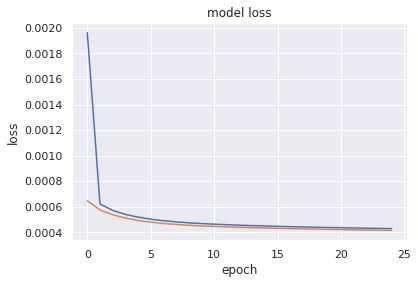

In [ ]:
plot_history(hist_v)

## Evaluation

In [24]:
# get sample predictions
all_predictions = model_v.predict(X)
all_predictions_df = pd.DataFrame(
    all_predictions,
    columns=interaction_matrix_df.columns,
    index=interaction_matrix_df.index,
).reset_index()
samples_df = all_predictions_df.sample(n=1000, random_state=7)
samples_df = (
    pd.melt(samples_df, id_vars=["session_id"], value_name="score")
    .sort_values(["session_id", "score"], ascending=[True, False], axis=0)
    .groupby("session_id")
    .head(10)
    .reset_index(drop=True)
)

y_true = []
y_pred = []

for session in samples_df.session_id.unique():
    y_true.append(list(log[log.session_id == session].track_id_clean.unique())[:10])
    y_pred.append(
        list(samples_df[samples_df.session_id == session].track_id_clean.unique())[:10]
    )
catalog = list(log.track_id_clean.unique())

print("map", mean_average_precision(y_pred, y_true))
print("coverage", coverage(y_pred, catalog))
print("personalization", personalization(y_pred))

map 0.35608623015873014
coverage 0.043
personalization 0.9712878878878879


## Visualization

In [27]:
for layer in model_v.layers:
    print(layer.name)


def get_encoder(model):
    layer_name = "z"
    encoder = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return encoder


encoder = get_encoder(model_v)

latent_space = encoder.predict(X)
print(latent_space.shape)
print(latent_space[0])

input_tracks
layer_encoder
layer_encoder_1d
z_mean
z_log_var
z
layer_decoder
layer_decoder_2
output_tracks
(18610, 256)
[-6.96117338e-03  9.12716016e-02  8.54723379e-02 -8.50005746e-02
 -1.30537048e-01 -1.40429556e-01  1.45903528e-02 -9.23403651e-02
 -1.77671373e-01 -6.85641319e-02 -4.07787710e-02  1.78331174e-02
  7.83613473e-02  8.36786702e-02  3.35896201e-02  1.93298399e-01
  2.49564741e-02  5.91789000e-03 -7.58801699e-02 -3.30268629e-02
  1.80268828e-02 -4.44302261e-02 -2.75910079e-01 -1.87215041e-02
 -1.72780752e-02  6.36578351e-02 -3.57369669e-02 -9.52294990e-02
 -1.61478408e-02  3.51727828e-02 -4.21131030e-03  8.14594328e-02
 -3.28227915e-02  6.62711402e-03  2.37393931e-01 -1.43358354e-02
  1.17627509e-01 -7.62231275e-02 -2.00040322e-02 -3.33070271e-02
  3.11188828e-02 -7.85252266e-03 -4.77532521e-02  6.81862235e-02
  7.21582631e-03  2.18959041e-02  8.74275118e-02 -1.60482116e-02
 -1.57168526e-02  9.70536750e-03 -9.96580496e-02 -1.73443276e-02
 -6.00298401e-03  1.05113111e-01  1

In [107]:
pip install MulticoreTSNE

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68502 sha256=4449b549a942689a15046b4a02e0843c0c4df765209aa9cfdf921af61093aabf
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [ ]:
tsne = TSNE(n_components=2, n_jobs=8)
x_reduce = tsne.fit_transform(latent_space)

In [ ]:
def scatter(x, color=None):
    plt.figure(figsize=(10, 10))
    plt.scatter(x[:, 0], x[:, 1], c=x[:, 0], alpha=0.4, s=3**2, cmap="Spectral")
    plt.grid(False)
    plt.show()

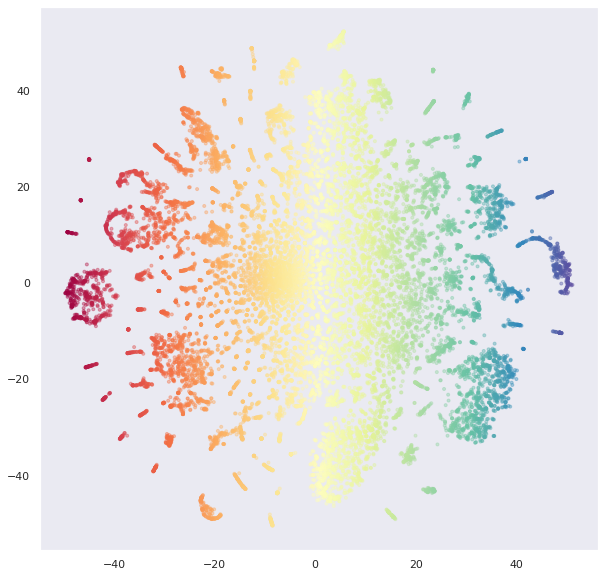

In [31]:
scatter(x_reduce)

# Model: Hybrid Filter

## Training

In [ ]:
# input
X = [interaction_matrix_df.values, content_data]
y = interaction_matrix_df.values

In [ ]:
def autoEncoderHybrid(X):
    """
    Autoencoder for Hybrid Filter (Collaborative + Content)
    """
    interaction_matrix, content_matrix = X

    # Inputs
    input_layer = Input(shape=(interaction_matrix.shape[1],), name="input_tracks")
    input_content = Input(shape=(content_matrix.shape[1],), name="input_content")

    # Encoder
    enc = Dense(512, activation="selu", name="layer_encoder_1")(input_layer)
    enc = Dropout(0.1, name="layer_encoder_1d")(enc)
    enc = Dense(256, activation="selu", name="layer_encoder_2")(enc)

    # Content
    x_content = Dense(256, activation="selu", name="layer_content_1")(input_content)
    x_content = Dropout(0.2, name="layer_content_1d")(x_content)
    x_content = Dense(128, activation="selu", name="layer_content_2")(x_content)

    # Latent Space
    lat_space = Dense(128, activation="selu", name="layer_latent")(enc)
    lat_space = add([lat_space, x_content], name="layer_latent_combined")
    lat_space = Dropout(0.2, name="layer_latent_1d")(lat_space)

    # Decoder
    dec = Dense(256, activation="selu", name="layer_decoder_1")(lat_space)
    dec = Dropout(0.1, name="layer_decoder_1d")(dec)
    dec = Dense(512, activation="selu", name="layer_decoder_2")(dec)

    # Output
    output_layer = Dense(
        interaction_matrix.shape[1], activation="linear", name="output_tracks"
    )(dec)

    model = Model([input_layer, input_content], output_layer)

    return model

In [89]:
# Build model
model_h = autoEncoderHybrid(X)
model_h.compile(optimizer=Adam(lr=0.001), loss="mse")
model_h.summary()

hist_h = model_h.fit(
    x=X, y=y, epochs=25, batch_size=64, shuffle=True, validation_split=0.1
)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tracks (InputLayer)       (None, 19845)        0                                            
__________________________________________________________________________________________________
layer_encoder_1 (Dense)         (None, 512)          10161152    input_tracks[0][0]               
__________________________________________________________________________________________________
input_content (InputLayer)      (None, 125)          0                                            
__________________________________________________________________________________________________
layer_encoder_1d (Dropout)      (None, 512)          0           layer_encoder_1[0][0]            
___________________________________________________________________________________________

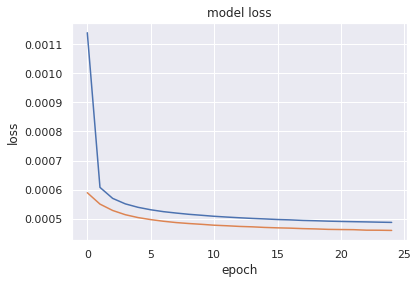

In [90]:
plot_hist(hist_h)

## Prediction

In [ ]:
new_matrix = model_h.predict(X) * (X[0] == 0.0)

In [92]:
new_interaction_matrix_df = pd.DataFrame(
    new_matrix, columns=interaction_matrix_df.columns, index=interaction_matrix_df.index
)
new_interaction_matrix_df.head()

track_id_clean,t_0000dc06-0c00-4a09-9dc6-3bdad9c6f0e8,t_00042d9b-e795-41a9-89ad-504373dd4287,t_0004aa5d-1e27-4446-995a-43ae94d2b490,t_000518e0-996c-46b0-9167-f831f5f8f513,t_0007a9bf-2faf-4345-b005-388b1d9e3d94,t_00094c95-4dc3-4d6f-afee-b91fda2294d1,t_000b6ec2-e98f-4f8e-a955-606e092b25f0,t_000c67b0-6ef3-48d6-97c9-29526f9d2d8d,t_000d49ad-9288-48c1-a429-efe379df99f7,t_00105455-8be7-4214-a8d5-ec8f6b52a79b,t_00138857-0bdb-47f1-a88f-5546118a575b,t_00174427-afef-4a1c-be96-38c2b6f01396,t_001fda0c-b887-4756-85de-9cf07eeb9f01,t_00210615-f083-4ef4-9c23-0922f3550d66,t_0022d7b7-65ce-4493-9f83-fb42314b7038,t_00296132-945b-4578-8722-0961db0c5063,t_002d7696-93f8-45a8-bb21-2a808933b408,t_003a1b5b-8de4-4b67-a7b9-63b4449d172f,t_003f8a4f-f4d1-42b9-b287-1462adcc36ec,t_004020a3-8f5d-47f5-9c06-b03cb0fd1c74,t_004bb228-a1ab-432a-b425-ada40f0e44bc,t_004c724a-2131-4f1c-9b0c-c824a196dbcb,t_005261c2-b5bd-4991-8a38-c0dbb05d0922,t_005987b9-82f0-4098-878e-905dd7ec4385,t_006061c2-f535-4117-9b66-be95948745b2,t_006081a8-0977-4833-8117-f2cfde6d60fd,t_00642388-12bc-4104-a63c-7db835fe0af4,t_0066326c-d776-4eae-a355-93ea0a05caab,t_006e18dd-7564-4850-8a29-86369ed86c8a,t_006feee8-27eb-4ff0-a2e0-f3d0a7815b31,t_007346de-1bbb-411b-8dd0-560ae72fdeb3,t_00750953-913d-4950-94a2-285b662c32f3,t_00796d06-2f3e-47ba-abb4-728da542de09,t_007eec3b-fa45-45a6-b913-9ae0a93dd7ba,t_0082520d-ab5f-48a1-b361-b30af55edf8d,t_008279d5-19ef-419e-b651-04031981bd99,t_0090dbf9-cd48-44d4-9207-413d9954c41a,t_00916c7c-e911-4445-b79a-0284830ea536,t_00919315-abf5-4869-9d25-213d27c51f73,t_0091e8b1-374a-4f3e-b0bd-f90687ad1f9a,...,t_ff9c77f6-8c8b-4a34-b118-95e81627e3c5,t_ff9cc39a-11b8-454d-a43a-1583f38b3494,t_ff9ce9d6-b330-44ec-8c97-6a78ce67adaf,t_ffa27fa4-7256-41ee-b317-a47868b96cec,t_ffa3b224-a4f5-420f-861e-d12b480f8a6b,t_ffa3f61c-0df6-4a3e-b462-0c88fad2c8ae,t_ffa51171-80a5-40fa-aa0a-b1aac6fec744,t_ffa60334-8bea-45b1-bde5-b91e5850ac4d,t_ffacec29-dced-4266-9112-4d14b6fbab8d,t_ffb11621-8bcb-4eed-94ad-b9fb2a0b2fd9,t_ffb1642a-0b78-4193-88a9-aa2b8525927b,t_ffb50689-9393-47c7-bf34-2a864e8eb478,t_ffb76fb9-3f42-4f0a-a09e-956df38e5c47,t_ffb7a66d-8398-4701-9119-0961b1af0b38,t_ffb7ca71-83d3-46f3-a579-d2630476ab74,t_ffbd2b1e-fe2d-4099-b5b8-de6cf97a6b20,t_ffbdb717-e7b9-46f5-bb2a-9c9ef0878f3a,t_ffc1338c-95d0-4669-88d8-4d90a6d08459,t_ffc37789-d3ce-4aa6-8e89-067ab0f18b21,t_ffc898b9-13f8-4338-8252-156b7b8dca71,t_ffc8991a-ba02-46ec-aa84-bf92269b5a45,t_ffc9a28f-1014-46e1-8d37-f8c3744752f3,t_ffc9f6c7-32da-4520-a661-2ddd714b74c1,t_ffcacf38-1cdb-4ce3-bd5e-648868c93180,t_ffce0dcf-87e9-4826-9499-f535b9b1caab,t_ffd4cf60-85ee-479b-afee-558a62da0555,t_ffd59094-8ee6-41bf-bc39-ca5e1148c6eb,t_ffd70455-5083-4171-92c4-e8b185e7666c,t_ffdf73bf-7b3b-476a-9031-e262fa3339e6,t_ffe124f6-1b3f-4b75-aa8d-10d6736309df,t_ffe4f45a-c85b-487e-b909-c9a401ab9130,t_ffe927bb-0453-409f-a420-65f2e9e493e7,t_ffecf968-2ea1-4fda-98e0-ebd43e313425,t_ffed690f-6007-4724-ae05-d4e948dd8f34,t_fff16c88-5073-4707-9204-bb56a43d1538,t_fff4a19e-bb6c-4e1e-baba-bbf846115ae7,t_fff5d444-7ab5-4332-a1c8-3c2416686299,t_fff9b035-3943-4557-bdd0-15fc2c5dc03e,t_fffb0ec7-cbd3-4075-bdad-7e57bada2a02,t_fffe4528-f29c-467c-a751-e9db03964faa
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0_0001df8e-1221-4079-adf3-b8ccfd23b8b6,0.000435,0.001877,-0.000424,-0.000071,0.000274,0.000159,0.002804,0.001961,-0.000762,0.000155,0.000455,0.000194,0.002896,0.000340,0.000273,-0.001247,0.000092,0.000008,0.000295,-0.000145,0.001340,0.000785,-0.000171,0.006075,0.002045,0.000257,0.000006,0.000392,0.005034,0.000071,0.000246,-0.000088,0.000203,0.000440,0.002570,0.006624,0.000461,0.000147,0.000321,0.001831,...,0.000392,-0.000060,-0.000930,-0.000005,0.002716,5.000286e-04,-0.000831,-0.000287,0.000259,0.002556,0.000524,-0.000022,0.002218,0.000252,-0.001816,0.003177,0.000111,-0.000046,0.000276,0.000209,0.000717,-1.048513e-04,-0.000249,0.000005,-0.000201,0.000120,0.000103,-0.000018,0.000590,0.000537,0.005348,-0.000078,0.001408,-0.000402,0.000151,0.002394,0.000751,-0.0

In [93]:
print(new_interaction_matrix_df.values.min(), new_interaction_matrix_df.values.max())

-0.2864763 1.2478577


In [94]:
session_id = "0_00168010-e7c4-4ef2-a2c1-b1cd227300ef"
recommender_for_session(
    id=session_id, interaction_matrix=interaction_matrix_df, top=10
).head()

NameError: ignored

In [ ]:
recommender_for_session(
    id=session_id, interaction_matrix=new_interaction_matrix_df, top=10
).head()

,score
track_id,
t_ccaa489d-2ce8-4267-ac9e-99c5a4bd5f82,0.151140
t_c62a6914-7fdb-4165-8e3e-77299df1372c,0.139506
t_262ad683-c6ca-410c-8518-01d0c75b8f61,0.131917
t_244d8a7e-a290-424d-9b2e-05b06426914d,0.130955
t_a4fffc7f-7c35-4c52-981e-5985172734be,0.129203
t_42d15744-c948-489e-a92b-9e664c170b57,0.119761
t_e67811c4-208a-4473-8034-c015f0f7736a,0.115221
t_8f9f2397-334b-48ee-9120-96d9ddf32f92,0.112052
t_2a55e695-7894-42aa-b920-52d1cbaf164c,0.111528


## Evaluation

In [95]:
# get sample predictions
all_predictions = model_h.predict(X)
all_predictions_df = pd.DataFrame(
    all_predictions,
    columns=interaction_matrix_df.columns,
    index=interaction_matrix_df.index,
).reset_index()
samples_df = all_predictions_df.sample(n=1000, random_state=7)
samples_df = (
    pd.melt(samples_df, id_vars=["session_id"], value_name="score")
    .sort_values(["session_id", "score"], ascending=[True, False], axis=0)
    .groupby("session_id")
    .head(10)
    .reset_index(drop=True)
)
samples_df.head()

,session_id,track_id_clean,score
0,0_00254bfb-1b1e-412f-a3a5-b3870f706b1b,t_8c4d29b1-e0bf-464c-88f7-ac19240cbba0,0.865584
1,0_00254bfb-1b1e-412f-a3a5-b3870f706b1b,t_32270005-26a1-4763-8ba5-44fcc15f9914,0.862620
2,0_00254bfb-1b1e-412f-a3a5-b3870f706b1b,t_0e3dec82-10b4-49f1-8c2e-cd19249f7d2c,0.859635
3,0_00254bfb-1b1e-412f-a3a5-b3870f706b1b,t_8f9f2397-334b-48ee-9120-96d9ddf32f92,0.856341
4,0_00254bfb-1b1e-412f-a3a5-b3870f706b1b,t_bacf06d3-9185-4183-84ea-ff0db51475ce,0.845630


In [ ]:
y_true = []
y_pred = []

for session in samples_df.session_id.unique():
    y_true.append(list(log[log.session_id == session].track_id_clean.unique())[:10])
    y_pred.append(
        list(samples_df[samples_df.session_id == session].track_id_clean.unique())[:10]
    )
catalog = list(log.track_id_clean.unique())

In [97]:
print("map", mean_average_precision(y_pred, y_true))
print("coverage", coverage(y_pred, catalog))
print("personalization", personalization(y_pred))

map 0.29665003968253967
coverage 0.0262
personalization 0.9587723723723723


## Visualization

In [111]:
for layer in model_h.layers:
    print(layer.name)

input_tracks
layer_encoder_1
input_content
layer_encoder_1d
layer_content_1
layer_encoder_2
layer_content_1d
layer_latent
layer_content_2
layer_latent_combined
layer_latent_1d
layer_decoder_1
layer_decoder_1d
layer_decoder_2
output_tracks


In [ ]:
def get_encoder(model):
    layer_name = "layer_latent_combined"
    encoder = Model(inputs=model_h.input, outputs=model.get_layer(layer_name).output)
    return encoder


encoder = get_encoder(model_h)

latent_space = encoder.predict(X)

In [ ]:
print(latent_space.shape)
print(latent_space[0])

(18610, 128)
[ 0.13264908 -0.00717945  0.19459802 -0.09444359  0.12336326 -0.15285301
  0.17034465  0.06472785  0.00379227  0.21172616  0.04376933  0.02343769
 -0.11225577  0.07469694  0.22691815  0.15102062 -0.00207825  0.20232718
  0.0337864   0.12976462  0.15447693  0.0250424   0.02850142 -0.06542853
  0.08567072 -0.0717066  -0.03498071  0.03752822  0.25391778  0.08235624
 -0.27290136  0.30833828 -0.13916565  0.08992603  0.20410557 -0.01628664
  0.2883514   0.05049999 -0.3304218  -0.2256865   0.0989001   0.12533107
 -0.16419384 -0.067018   -0.07452225 -0.01312201  0.12863827  0.21475495
 -0.02948809  0.00689134  0.0650375   0.16496612  0.2627983   0.21901803
  0.51634777  0.05111828 -0.1505139   0.24163972  0.3656292  -0.00156768
  0.1546864  -0.02716829 -0.06386125  0.41365197  0.34761652  0.03477527
 -0.10279302 -0.06602108  0.1268632   0.3834096   0.15112129  0.2144969
 -0.14183214 -0.15645905 -0.31781012  0.07540853 -0.10524768  0.07323886
 -0.16310817  0.0620482   0.07561767 -0

In [114]:
session_types.describe()

,release_year,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
count,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000
mean,0.953117,0.218217,0.561964,0.602833,0.688638,0.221479,0.620471,0.912072,0.019297,0.182552,0.839949,0.608454,0.351640,0.150404,0.498654,0.790791,0.451935,0.265252,0.733430,0.725625,0.419247,0.433251,0.761851,0.254536,0.495970
std,0.115462,0.145913,0.107991,0.127320,0.101913,0.042209,0.106655,0.021674,0.091753,0.066793,0.034194,0.123064,0.118962,0.086436,0.051874,0.033919,0.133587,0.151673,0.068089,0.074733,0.103606,0.125180,0.061245,0.129463,0.099904
min,0.123950,0.000000,0.065000,0.049242,0.106061,0.070816,0.015714,0.380631,0.000000,0.050000,0.449676,0.090000,0.041237,0.027491,0.291706,0.466667,0.000000,0.066748,0.225042,0.232517,0.076583,0.083763,0.318841,0.080000,0.070574
25%,0.966176,0.118000,0.486667,0.516595,0.626263,0.190748,0.561250,0.903904,0.000000,0.138000,0.829141,0.543333,0.270619,0.084192,0.466152,0.800000,0.363636,0.145190,0.723858,0.709790,0.365511,0.362113,0.718427,0.171429,0.485646
50%,0.987395,0.184286,0.567143,0.618687,0.696970,0.223994,0.621250,0.915315,0.000000,0.172500,0.845871,0.625714,0.333333,0.144330,0.498427,0.800000,0.434343,0.208738,0.746193,0.734266,0.444330,0.380707,0.753623,0.216190,0.536364
75%,0.998162,0.285000,0.642500,0.702479,0.761364,0.253130,0.683750,0.924067,0.004000,0.214000,0.858137,0.696000,0.412371,0.201031,0.531822,0.800000,0.527273,0.347896,0.767343,0.762238,0.482245,0.456186,0.809783,0.291429,0.549442
max,1.000000,0.997500,0.890000,0.929293,0.979798,0.408712,1.000000,0.972973,0.997500,0.868000,0.922797,0.970000,0.948454,0.972509,0.806342,0.900000,0.974747,0.922330,0.943437,0.913753,0.832474,0.916881,0.969203,0.918571,0.907895


In [115]:
session_types["summary"] = np.where(
    ((session_types["bounciness"] > 0.7) & (session_types["danceability"] > 0.8)),
    "dancy_bouncy",
    np.nan,
)
session_types["summary"] = np.where(
    (
        (session_types["instrumentalness"] > 0.5)
        & (session_types["acousticness"] > 0.28)
    ),
    "acoustic",
    session_types["summary"],
)
session_types["summary"] = np.where(
    ((session_types["acoustic_vector_5"] > 0.8)), "vec_5", session_types["summary"]
)
session_types["summary"] = np.where(
    ((session_types["acoustic_vector_3"] > 0.6)), "vec_3", session_types["summary"]
)
session_types.groupby("summary")["session_id"].count().reset_index()

,summary,session_id
0,acoustic,143
1,dancy_bouncy,2320
2,nan,10396
3,vec_3,419
4,vec_5,5332


### TSNE

In [ ]:
tsne = TSNE(n_components=2, n_jobs=8, perplexity=50, n_iter=500, learning_rate=40)
x_reduce = tsne.fit_transform(latent_space)

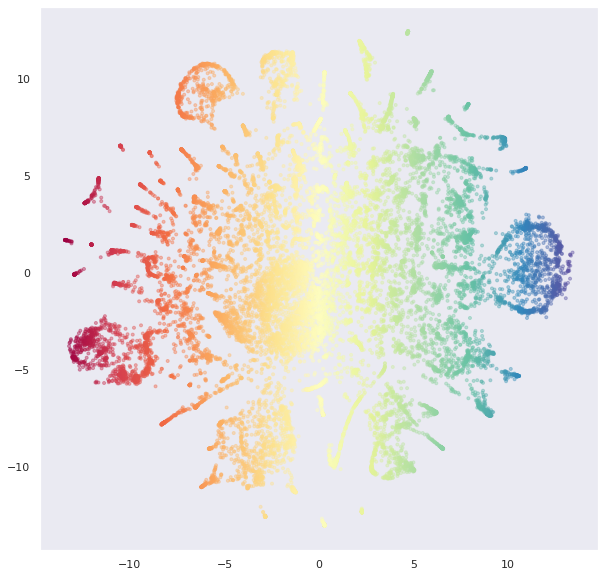

In [118]:
scatter(x_reduce)

In [119]:
cols = ["emb_" + str(i) for i in range(2)]
emb = tsne.embedding_
session_types[cols[0]], session_types[cols[1]] = emb[:, 0], emb[:, 1]
session_types.describe()

,release_year,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,emb_0,emb_1
count,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,18605.000000,1.861000e+04,1.861000e+04
mean,0.953117,0.218217,0.561964,0.602833,0.688638,0.221479,0.620471,0.912072,0.019297,0.182552,0.839949,0.608454,0.351640,0.150404,0.498654,0.790791,0.451935,0.265252,0.733430,0.725625,0.419247,0.433251,0.761851,0.254536,0.495970,-3.130817e-17,-2.170573e-16
std,0.115462,0.145913,0.107991,0.127320,0.101913,0.042209,0.106655,0.021674,0.091753,0.066793,0.034194,0.123064,0.118962,0.086436,0.051874,0.033919,0.133587,0.151673,0.068089,0.074733,0.103606,0.125180,0.061245,0.129463,0.099904,6.100248e+00,5.506079e+00
min,0.123950,0.000000,0.065000,0.049242,0.106061,0.070816,0.015714,0.380631,0.000000,0.050000,0.449676,0.090000,0.041237,0.027491,0.291706,0.466667,0.000000,0.066748,0.225042,0.232517,0.076583,0.083763,0.318841,0.080000,0.070574,-1.341284e+01,-1.306662e+01
25%,0.966176,0.118000,0.486667,0.516595,0.626263,0.190748,0.561250,0.903904,0.000000,0.138000,0.829141,0.543333,0.270619,0.084192,0.466152,0.800000,0.363636,0.145190,0.723858,0.709790,0.365511,0.362113,0.718427,0.171429,0.485646,-4.336279e+00,-3.669162e+00
50%,0.987395,0.184286,0.567143,0.618687,0.696970,0.223994,0.621250,0.915315,0.000000,0.172500,0.845871,0.625714,0.333333,0.144330,0.498427,0.800000,0.434343,0.208738,0.746193,0.734266,0.444330,0.380707,0.753623,0.216190,0.536364,-1.475237e-01,-8.529363e-02
75%,0.998162,0.285000,0.642500,0.702479,0.761364,0.253130,0.683750,0.924067,0.004000,0.214000,0.858137,0.696000,0.412371,0.201031,0.531822,0.800000,0.527273,0.347896,0.767343,0.762238,0.482245,0.456186,0.809783,0.291429,0.549442,4.546372e+00,3.912478e+00
max,1.000000,0.997500,0.890000,0.929293,0.979798,0.408712,1.000000,0.972973,0.997500,0.868000,0.922797,0.970000,0.948454,0.972509,0.806342,0.900000,0.974747,0.922330,0.943437,0.913753,0.832474,0.916881,0.969203,0.918571,0.907895,1.340089e+01,1.244815e+01


In [121]:
session_types["cluster"] = np.where(
    ((session_types["emb_1"] > 10)), "cluster_1", np.nan
)
session_types.groupby("cluster").agg(["mean"]).reset_index()

,cluster,release_year,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,emb_0,emb_1
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,cluster_1,0.956302,0.220701,0.564326,0.605289,0.690028,0.222405,0.619913,0.911864,0.016392,0.186600,0.841256,0.611050,0.351720,0.151567,0.497416,0.791793,0.452656,0.262808,0.737417,0.726487,0.418973,0.433043,0.762814,0.257643,0.498848,0.050420,10.968588
1,nan,0.952982,0.218111,0.561864,0.602729,0.688579,0.221440,0.620495,0.912080,0.019420,0.182381,0.839894,0.608344,0.351636,0.150355,0.498707,0.790749,0.451905,0.265355,0.733261,0.725588,0.419258,0.433259,0.761810,0.254405,0.495849,-0.002132,-0.463808


## Popular

In [ ]:
y_true = []
y_pred = []
top_10 = (
    log.groupby(["track_id_clean"])["counts"]
    .sum()
    .reset_index()
    .sort_values(by="counts", ascending=False)
    .head(10)
    .track_id_clean.tolist()
)

for session in samples_df.session_id.unique():
    y_true.append(list(log[log.session_id == session].track_id_clean.unique())[:10])
    y_pred.append(top_10)
catalog = list(log.track_id_clean.unique())

In [129]:
print("map", mean_average_precision(y_pred, y_true))
print("coverage", coverage(y_pred, catalog))
print("personalization", personalization(y_pred))

map 0.032462341269841266
coverage 0.0003
personalization 1.1102230246251565e-16


# Appendix

### SpotiPy

In [ ]:
pip install spotipy --upgradelog

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(
    client_id=cid, client_secret=secret
)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
artist_name = []
track_name = []
popularity = []
track_id = []
for i in range(0, 100, 50):
    track_results = sp.search(q="year:2018", type="track", limit=50, offset=i)
    for i, t in enumerate(track_results["tracks"]["items"]):
        artist_name.append(t["artists"][0]["name"])
        track_name.append(t["name"])
        track_id.append(t["id"])
        popularity.append(t["popularity"])

In [ ]:
track_dataframe = pd.DataFrame(
    {
        "artist_name": artist_name,
        "track_name": track_name,
        "track_id": track_id,
        "popularity": popularity,
    }
)
print(track_dataframe.shape)
track_dataframe.head()

(100, 4)


,artist_name,track_name,track_id,popularity
0,Trevor Daniel,Falling,4TnjEaWOeW0eKTKIEvJyCa,96
1,Juice WRLD,Lucid Dreams,285pBltuF7vW8TeWk8hdRR,88
2,Juice WRLD,All Girls Are The Same,4VXIryQMWpIdGgYR4TrjT1,84
3,Billie Eilish,lovely (with Khalid),0u2P5u6lvoDfwTYjAADbn4,89
4,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,3KkXRkHbMCARz0aVfEt68P,86


In [ ]:
from IPython.display import Image
from IPython.core.display import HTML

lz_uri = "spotify:artist:36QJpDe2go2KgaRleHCDTp"

results = sp.artist_top_tracks(lz_uri)

for track in results["tracks"][:10]:
    print("track    : " + track["name"])
    print("audio    : " + track["preview_url"])
    print("cover art: " + track["album"]["images"][0]["url"])
    print()

track    : Stairway to Heaven - 2012 Remaster
audio    : https://p.scdn.co/mp3-preview/8226164717312bc411f8635580562d67e191a754?cid=0669132653714d7380cf251a62eceda1
cover art: https://i.scdn.co/image/ab67616d0000b273c8a11e48c91a982d086afc69

track    : Immigrant Song - Remaster
audio    : https://p.scdn.co/mp3-preview/8455599677a13017978dcd3f4b210937f0a16bcb?cid=0669132653714d7380cf251a62eceda1
cover art: https://i.scdn.co/image/ab67616d0000b27390a50cfe99a4c19ff3cbfbdb

track    : Whole Lotta Love - 1990 Remaster
audio    : https://p.scdn.co/mp3-preview/ce11b19a4d2de9976d7626df0717d0073863909c?cid=0669132653714d7380cf251a62eceda1
cover art: https://i.scdn.co/image/ab67616d0000b273fc4f17340773c6c3579fea0d

track    : Black Dog - 2012 Remaster
audio    : https://p.scdn.co/mp3-preview/9b76619fd9d563a48d38cc90ca00c3008327b52e?cid=0669132653714d7380cf251a62eceda1
cover art: https://i.scdn.co/image/ab67616d0000b273c8a11e48c91a982d086afc69

track    : Good Times Bad Times - 1993 Remaster
audi